## Data100 Final Project




**Robin Shao, David Shen**

In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import codecs, json

In [2]:
# import data including the extra dataset we create
college = pd.DataFrame(pd.read_csv('college.csv'))
nba = pd.DataFrame(pd.read_csv('Basketball-PlayerBoxScore.csv'))

with codecs.open('drafting.txt', 'r', encoding='utf8') as f:
    text = f.read()
draft_data = json.loads(text)
draft = pd.DataFrame(draft_data["resultSets"][0]['rowSet'], columns = draft_data["resultSets"][0]['headers'])\
        .astype({'SEASON': 'int64', 'OVERALL_PICK': 'int64'})
draft

,PERSON_ID,PLAYER_NAME,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK,DRAFT_TYPE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,ORGANIZATION,ORGANIZATION_TYPE
0,1629627,Zion Williamson,2019,1,1,1,Draft,1610612740,New Orleans,Pelicans,NOP,Duke,College/University
1,1629630,Ja Morant,2019,1,2,2,Draft,1610612763,Memphis,Grizzlies,MEM,Murray State,College/University
2,1629628,RJ Barrett,2019,1,3,3,Draft,1610612752,New York,Knicks,NYK,Duke,College/University
3,1629631,De'Andre Hunter,2019,1,4,4,Draft,1610612747,Los Angeles,Lakers,LAL,Virginia,College/University
4,1629636,Darius Garland,2019,1,5,5,Draft,1610612739,Cleveland,Cavaliers,CLE,Vanderbilt,College/University
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,79322,Charles Raynor,1947,0,0,0,Draft,1610610024,Baltimore,Bullets,BAL,Houston,College/University
8019,77686,Paul Napolitano,1947,0,0,0,Draft,1610610034,St. Louis,Bombers,BOM,San Francisco,College/University
8020,77684,Fred Nagy,1947,0,0,0,Draft,1610610031,Pittsburgh,Ironmen,PIT,Akron,College/University
8021,79320,Bob Jake,1947,0,0,0,Draft,1610610024,Baltimore,Bullets,BAL,Vermont,College/University


In [3]:
# create dataframe for players not going to US colleges
missing_college = college[college['college'].isnull()]
print(np.sum(missing_college['NCAA_games'].isna()) == len(missing_college.index))
missing_college.shape

True


(302, 34)

In [4]:
# create dataframe for players not playing a single game
missing_games = college[college['NCAA_games'].isnull()]
print(np.sum(missing_games['NCAA_fgpg'].isna()) == len(missing_games.index))
missing_games.shape

True


(1978, 34)

In [5]:
# get rid of players not playing in US colleges or have not played any games
college = college[(~college['college'].isnull()) & (~college['NCAA_games'].isnull())]

#calculate active years of each player
college['nba_years'] = college['active_to'] - college['active_from'] + 1

#calculate active years of each player in the span from 2012 to 2018
def YearInData (row):
    if row['active_from'] < 2012:
        if row['active_to'] < 2012:
            return 0
        else:
            return row['active_to'] - 2012 + 1
    else:
        return row['active_to'] - row['active_from'] + 1

college['years_in_span'] = college.apply(lambda row: YearInData(row), axis = 1)


# choose college players meeting 2 criteria to do further analysis:
# 1. the number of years active in the time period of 2012-2018 is more than half of the whole career
# 2. active year in the time period is longer than 1 year
college_chosen = college[((college['years_in_span'] / college['nba_years']) > 0.5) & (college['years_in_span'] > 1)]

college_chosen.shape

(467, 36)

In [6]:
# convert player birthday to birth year
def GetBirthYear (date):
    return pd.to_datetime(date).year
college_chosen.loc[:, 'birth_year'] = college_chosen.loc[:, 'birth_date'].apply(GetBirthYear)

# convert height in feet to inches
r = re.compile(r'([0-9]+)\-([0-9]+)')
def GetInches(el):
    m = r.match(el)
    return int(m.group(1))*12 + float(m.group(2))
college_chosen.loc[:,'good_height'] = college_chosen.loc[:, 'height'].apply(GetInches)

# choose the priority position
r1 = re.compile(r'([A-Z]+)\-?([A-Z]+)?')
def Get1stPosition(el):
    m = r1.match(el)
    return m.group(1)
college_chosen.loc[:,'first_position'] = college_chosen.loc[:, 'position'].apply(Get1stPosition)


college_chosen

C:\Users\Robin\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Robin\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Unnamed: 0,active_from,active_to,birth_date,college,height,name,position,url,weight,...,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg,nba_years,years_in_span,birth_year,good_height,first_position
14,14,2013,2018,"October 6, 1990",Baylor University,6-7,Quincy Acy,F,/players/a/acyqu01.html,240.0,...,0.708,3.6,2.5,139.0,9.8,6,6,1990,79.0,F
19,19,2015,2016,"July 8, 1994","University of California, Los Angeles",6-5,Jordan Adams,G,/players/a/adamsjo01.html,209.0,...,0.839,5.0,4.2,69.0,16.4,2,2,1994,77.0,G
21,21,2014,2018,"July 20, 1993",University of Pittsburgh,7-0,Steven Adams,C,/players/a/adamsst01.html,255.0,...,0.443,2.2,1.0,32.0,7.2,5,5,1993,84.0,C
25,25,2011,2015,"February 10, 1986",University of Connecticut,6-7,Jeff Adrien,F,/players/a/adrieje01.html,245.0,...,0.606,4.9,3.0,133.0,12.1,5,4,1986,79.0,F
26,26,2008,2018,"October 15, 1985","University of California, Los Angeles",6-5,Arron Afflalo,G,/players/a/afflaar01.html,210.0,...,0.781,3.6,2.8,104.0,14.8,11,7,1985,77.0,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547,4547,2016,2018,"June 27, 1992","University of Houston, University of Oregon",6-2,Joe Young,G,/players/y/youngjo01.html,180.0,...,0.886,3.9,3.5,132.0,17.5,3,3,1992,74.0,G
4550,4550,2008,2018,"June 1, 1985",University of Southern California,6-7,Nick Young,G-F,/players/y/youngni01.html,210.0,...,0.764,3.9,3.0,96.0,15.5,11,7,1985,79.0,G
4553,4553,2008,2018,"June 21, 1988",Georgia Institute of Technology,6-8,Thaddeus Young,F,/players/y/youngth01.html,221.0,...,0.743,2.3,1.7,31.0,14.4,11,7,1988,80.0,F
4558,4558,2014,2018,"October 5, 1992",Indiana University,7-0,Cody Zeller,C-F,/players/z/zelleco01.html,240.0,...,0.756,6.6,5.0,72.0,16.1,5,5,1992,84.0,C


In [7]:
# change the form of name for NBA players data
nba['full_name'] = nba['playFNm'] + ' ' + nba['playLNm']

In [8]:
# get each player's NBA average data in NBA from NBAplayerboxscore 
# (Note: after taking mean, the data related to shooting percentage 
# are wrong because some players may just did not shoot in some games,
# we will solve this by using data from college dataset)
nba_mean = nba.groupby('full_name').mean()
nba_mean
nba_mean['playMin']

full_name
A.J. Price        15.333333
Aaron Brooks      17.790885
Aaron Gordon      26.133080
Aaron Gray        10.974684
Aaron Hammons      7.272727
                    ...    
Zach Randolph     30.276347
Zachary LaVine    28.713043
Zaza Pachulia     21.442748
Zhou Qi            6.833333
Zoran Dragić       4.687500
Name: playMin, Length: 941, dtype: float64

In [9]:
# filter the players who played fewer than 300 minutes in total or 1 minue per game
nba_sum = nba.groupby('full_name').sum()
nba_mean['sum_time'] = nba_sum['playMin']
nba_mean = nba_mean.loc[(nba_mean['sum_time'] > 300) & (nba_mean['playMin'] > 1), :]
nba_mean

,teamDayOff,playMin,playHeight,playWeight,playPTS,playAST,playTO,playSTL,playBLK,playPF,...,play3PM,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,opptDayOff,sum_time
full_name,,,,,,,,,,,,,,,,,,,,,
A.J. Price,2.099099,15.333333,74.0,195.0,5.567568,2.378378,0.765766,0.369369,0.027027,0.837838,...,0.819820,0.221242,0.792793,0.585586,0.195474,0.243243,1.162162,1.405405,2.018018,1702
Aaron Brooks,1.884718,17.790885,72.0,161.0,7.675603,2.501340,1.337802,0.528150,0.152815,1.825737,...,1.050938,0.295815,1.168901,0.957105,0.349343,0.359249,1.176944,1.536193,1.916890,6636
Aaron Gordon,1.923954,26.133080,81.0,225.0,11.418251,1.688213,1.144487,0.771863,0.619772,1.973384,...,0.939163,0.253851,2.646388,1.847909,0.483481,1.532319,4.311787,5.844106,1.798479,6873
Aaron Gray,2.000000,10.974684,84.0,270.0,2.329114,0.696203,0.848101,0.215190,0.164557,1.886076,...,0.000000,0.000000,0.810127,0.430380,0.178270,1.139241,1.949367,3.088608,2.063291,867
Aaron Harrison,1.742857,9.914286,78.0,213.0,2.257143,0.457143,0.200000,0.428571,0.057143,1.114286,...,0.342857,0.125940,0.885714,0.542857,0.173811,0.228571,0.971429,1.200000,1.714286,347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xavier Henry,2.039216,15.852941,78.0,220.0,6.333333,0.656863,0.892157,0.617647,0.117647,1.539216,...,0.313725,0.123693,2.872549,1.843137,0.412430,0.470588,1.568627,2.039216,2.058824,1617
Zach Collins,1.818182,15.833333,84.0,230.0,4.424242,0.787879,0.893939,0.257576,0.469697,2.015152,...,0.530303,0.251009,0.636364,0.409091,0.195708,0.681818,2.666667,3.348485,2.060606,1045
Zach Randolph,1.955504,30.276347,81.0,253.0,15.477752,1.995316,1.899297,0.718970,0.238876,2.262295,...,0.208431,0.101156,3.398126,2.576112,0.620127,2.948478,6.231850,9.180328,1.906323,12928


In [10]:
# calculate the PER (comprehensive evaluation of player performance) in NBA for each player
nba_mean['nba_per'] = (85.910 * nba_mean['playFGM'] + 53.897 * nba_mean['playSTL'] + 51.757 * nba_mean['play3PM']
                       + 46.845 * nba_mean['playFTM'] + 39.190 * nba_mean['playBLK'] + 39.190 * nba_mean['playORB'] 
                       + 34.677 * nba_mean['playAST'] + 14.707 * nba_mean['playDRB'] - 17.174 * nba_mean['playPF']
                       - 20.091 * nba_mean['playFTM'] - 39.190 * nba_mean['playFGM'] 
                       - 53.897 * nba_mean['playTO'])/ nba_mean['playMin']

nba_mean['nba_per']

full_name
A.J. Price        14.982490
Aaron Brooks      14.699499
Aaron Gordon      17.295835
Aaron Gray         8.498896
Aaron Harrison     9.967867
                    ...    
Xavier Henry      12.034497
Zach Collins      10.266902
Zach Randolph     18.480084
Zachary LaVine    15.432017
Zaza Pachulia     15.501298
Name: nba_per, Length: 724, dtype: float64

In [11]:
# create a dataframe with only college information and set index to be the name of the player
college_features = ['name', 'college',  'first_position', 'position', 'birth_year', 'good_height', 'weight',
                    'NCAA__3ptapg', 'NCAA__3ptpct', 'NCAA__3ptpg', 'NCAA_fgapg','NCAA_fgpct', 'NCAA_fgpg',
                    'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']

pure_college = college_chosen.loc[:, college_features].drop_duplicates(subset ="name").set_index('name')
pure_college

,college,first_position,position,birth_year,good_height,weight,NCAA__3ptapg,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
name,,,,,,,,,,,,,,,,,
Quincy Acy,Baylor University,F,F,1990,79.0,240.0,0.1,0.429,0.0,6.0,0.602,3.6,0.708,3.6,2.5,139.0,9.8
Jordan Adams,"University of California, Los Angeles",G,G,1994,77.0,209.0,4.3,0.331,1.4,11.6,0.467,5.4,0.839,5.0,4.2,69.0,16.4
Steven Adams,University of Pittsburgh,C,C,1993,84.0,255.0,0.0,NaN,0.0,5.5,0.571,3.1,0.443,2.2,1.0,32.0,7.2
Jeff Adrien,University of Connecticut,F,F,1986,79.0,245.0,0.0,0.333,0.0,8.8,0.515,4.5,0.606,4.9,3.0,133.0,12.1
Arron Afflalo,"University of California, Los Angeles",G,G,1985,77.0,210.0,5.4,0.373,2.0,10.9,0.457,5.0,0.781,3.6,2.8,104.0,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Joe Young,"University of Houston, University of Oregon",G,G,1992,74.0,180.0,5.6,0.390,2.2,13.0,0.453,5.9,0.886,3.9,3.5,132.0,17.5
Nick Young,University of Southern California,G,G-F,1985,79.0,210.0,2.7,0.368,1.0,11.9,0.484,5.8,0.764,3.9,3.0,96.0,15.5
Thaddeus Young,Georgia Institute of Technology,F,F,1988,80.0,221.0,3.0,0.419,1.3,11.9,0.478,5.7,0.743,2.3,1.7,31.0,14.4


In [12]:
# create a data frame with only NBA information with data from both PlayerBoxScore and College dataset
nba_features_from_nba = ['teamDayOff', 'playMin', 'playHeight', 'playWeight', 'playPTS', 'playAST', 'playTO',
                         'playSTL', 'playBLK', 'playPF', 'playFGA', 'playFGM','play2PA', 'play2PM', 'play3PA',
                         'play3PM', 'playFTA', 'playFTM', 'playORB', 'playDRB', 'playTRB', 'opptDayOff','nba_per']
nba_features_from_college = ['name', 'nba_years','NBA__3ptapg', 'NBA__3ptpct', 'NBA__3ptpg', 'NBA_efgpct',
                             'NBA_fg%', 'NBA_fg_per_game','NBA_fga_per_game','NBA_ft%', 'NBA_ft_per_g',
                             'NBA_fta_p_g', 'NBA_g_played', 'NBA_ppg']

x = nba_mean.loc[:,nba_features_from_nba]
y = college_chosen.loc[:, nba_features_from_college]
pure_nba = y.merge(x, left_on = college_chosen['name'], right_on = nba_mean.index).drop('key_0', 1)\
           .drop_duplicates(subset ="name").set_index('name')
pure_nba

,nba_years,NBA__3ptapg,NBA__3ptpct,NBA__3ptpg,NBA_efgpct,NBA_fg%,NBA_fg_per_game,NBA_fga_per_game,NBA_ft%,NBA_ft_per_g,...,play2PM,play3PA,play3PM,playFTA,playFTM,playORB,playDRB,playTRB,opptDayOff,nba_per
name,,,,,,,,,,,,,,,,,,,,,
Quincy Acy,6,1.5,0.355,0.5,0.516,0.446,1.8,4.0,0.761,0.9,...,1.217125,1.556575,0.553517,1.149847,0.874618,0.935780,2.593272,3.529052,2.036697,12.461908
Steven Adams,5,0.0,0.000,0.0,0.585,0.585,3.6,6.1,0.566,1.6,...,3.599483,0.015504,0.000000,2.790698,1.583979,3.162791,3.767442,6.930233,1.945736,14.938237
Jeff Adrien,5,0.0,0.000,0.0,0.474,0.474,1.7,3.6,0.628,1.2,...,1.918033,0.016393,0.000000,2.106557,1.336066,1.581967,3.163934,4.745902,1.950820,15.272729
Arron Afflalo,11,2.9,0.386,1.1,0.514,0.449,3.9,8.7,0.825,1.8,...,3.363409,3.335840,1.248120,2.523810,2.122807,0.313283,2.709273,3.022556,1.944862,12.768536
Cole Aldrich,8,0.0,NaN,0.0,0.527,0.527,1.3,2.4,0.738,0.5,...,1.372881,0.000000,0.000000,0.766102,0.559322,1.040678,2.508475,3.549153,1.928814,16.114497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
James Young,4,1.4,0.277,0.4,0.457,0.367,0.8,2.2,0.563,0.3,...,0.410526,1.442105,0.400000,0.505263,0.284211,0.200000,0.810526,1.010526,2.105263,10.821472
Nick Young,11,3.9,0.376,1.4,0.493,0.418,4.0,9.7,0.835,1.9,...,2.008357,4.922006,1.846797,2.206128,1.860724,0.364903,1.732591,2.097493,2.033426,15.876613
Thaddeus Young,11,1.3,0.326,0.4,0.517,0.499,5.8,11.6,0.675,1.4,...,5.620915,1.623094,0.520697,2.087146,1.322440,2.108932,4.603486,6.712418,1.873638,16.909110


In [13]:
#set pure_college to be same group of player
pure_college = pure_college[pure_college.index.isin(pure_nba.index)]
pure_college

,college,first_position,position,birth_year,good_height,weight,NCAA__3ptapg,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
name,,,,,,,,,,,,,,,,,
Quincy Acy,Baylor University,F,F,1990,79.0,240.0,0.1,0.429,0.0,6.0,0.602,3.6,0.708,3.6,2.5,139.0,9.8
Steven Adams,University of Pittsburgh,C,C,1993,84.0,255.0,0.0,NaN,0.0,5.5,0.571,3.1,0.443,2.2,1.0,32.0,7.2
Jeff Adrien,University of Connecticut,F,F,1986,79.0,245.0,0.0,0.333,0.0,8.8,0.515,4.5,0.606,4.9,3.0,133.0,12.1
Arron Afflalo,"University of California, Los Angeles",G,G,1985,77.0,210.0,5.4,0.373,2.0,10.9,0.457,5.0,0.781,3.6,2.8,104.0,14.8
Cole Aldrich,University of Kansas,C,C,1988,83.0,250.0,0.0,NaN,0.0,6.1,0.574,3.5,0.729,3.2,2.3,111.0,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
James Young,University of Kentucky,G,G-F,1995,78.0,215.0,5.9,0.349,2.1,11.3,0.407,4.6,0.706,4.4,3.1,40.0,14.3
Nick Young,University of Southern California,G,G-F,1985,79.0,210.0,2.7,0.368,1.0,11.9,0.484,5.8,0.764,3.9,3.0,96.0,15.5
Thaddeus Young,Georgia Institute of Technology,F,F,1988,80.0,221.0,3.0,0.419,1.3,11.9,0.478,5.7,0.743,2.3,1.7,31.0,14.4


In [14]:
# get cleaned dataframe containging college and NBA performance of all the selected players
# some players with low minutes are not contained here somehow
all_cleaned = pure_college.merge(pure_nba, left_on = pure_college.index, right_on = pure_nba.index)\
              .rename(columns={'key_0' : 'name'}).set_index('name')

# a brief list of top players
all_cleaned['nba_per'].sort_values(ascending = False).head(20)

name
Russell Westbrook     28.346649
Kevin Durant          26.169681
James Harden          26.143174
Chris Paul            25.887433
Anthony Davis         25.329693
Joel Embiid           25.038553
DeMarcus Cousins      24.462059
Kevin Love            22.965582
Karl-Anthony Towns    22.842619
John Wall             22.271147
Kyrie Irving          22.184916
Kawhi Leonard         22.104585
Damian Lillard        22.063991
Hassan Whiteside      22.011236
Blake Griffin         21.888598
Isaiah Thomas         21.726358
Andre Drummond        21.685152
LaMarcus Aldridge     21.455490
Kemba Walker          21.447847
Kyle Lowry            21.227662
Name: nba_per, dtype: float64

In [15]:
###### all cleaned with college cleaned (not successful, see anser for quetion 3) #######
copy_clean = all_cleaned
results = set()
copy_clean['seperate'] = copy_clean['college'].str.split(',')
copy_clean['seperate'].apply(results.update)
#results = list(results)
results
def good (name):
    return (('University' in name) or ('College' in name) or ('Institute' in name)) and (',' not in name)
results.update(copy_clean['college'].values)
g = list(filter(good, list(results)))


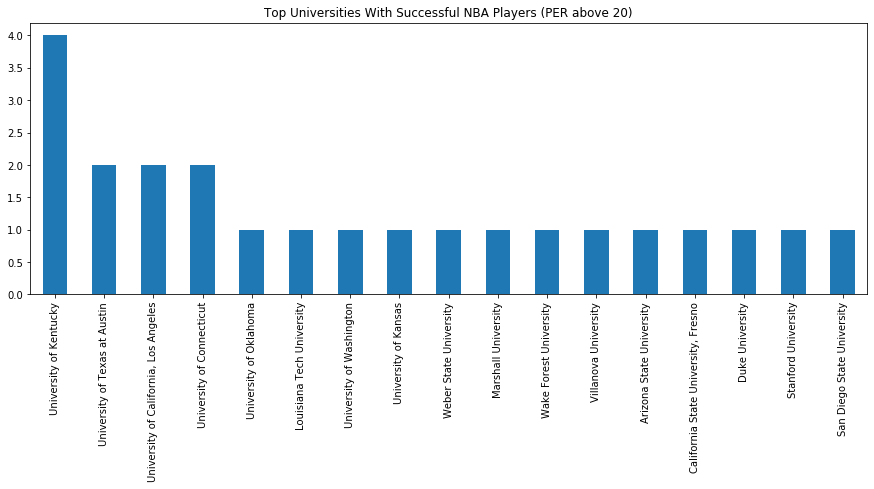

In [16]:
# plot colleges with most successful NBA players (PER above 20). 
# We can see University of Kentucky really stands out
all_star = all_cleaned.loc[all_cleaned['nba_per'] > 20]
top_schools = all_star['college'].value_counts()
plt.figure(figsize=(15, 5))
plt.title("Top Universities With Successful NBA Players (PER above 20)")
top_schools.plot(kind = 'bar')
plt.show()

In [17]:
# create dataframe of number of weird zeros in each season when zero occurs
# There should not be any zeros in the columns 'ROUND_NUMBER', 'ROUND_PICK', 'OVERALL_PICK'
# because the pick order starts at 1. Hence we find the years which had corrupt data and drop them.
zeros_in_draft = draft.groupby('SEASON').apply(lambda x: x[x == 0].count())[['ROUND_NUMBER', 'ROUND_PICK', 'OVERALL_PICK']]
zeros_in_draft[zeros_in_draft['OVERALL_PICK'] > 0]

,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK
SEASON,,,
1947,70,70,70
1948,101,101,101
1949,38,65,65
1950,1,110,110
1951,1,1,1
1952,87,106,97
1953,89,115,115
1955,36,57,57
1956,76,85,85


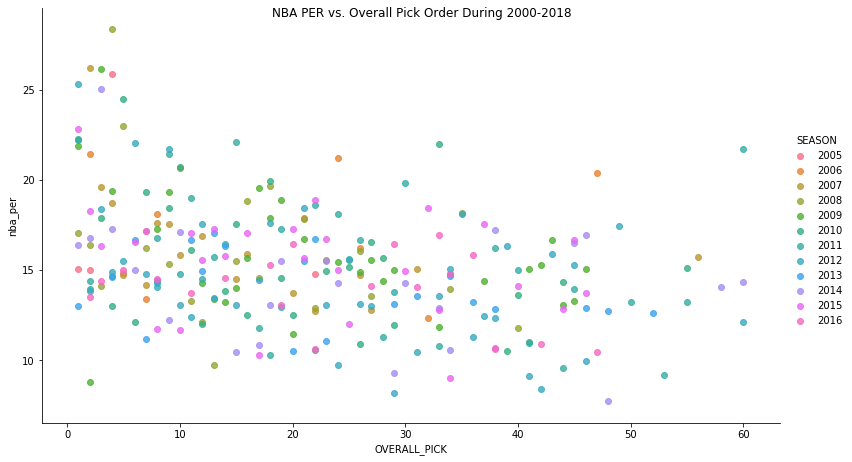

In [18]:
# draw a scatter plot showing the overall picks of all the players in 'all_cleaned' dataframe which
# is the group of players we choose to do further research
# Basically, superstars are all top picks
draft = draft[draft['SEASON'] > 1965]
%matplotlib inline
draft_all_cleaned = all_cleaned.merge(draft[['PLAYER_NAME', 'SEASON', 'OVERALL_PICK']], left_on=all_cleaned.index,
                                      right_on='PLAYER_NAME').rename(columns={'PLAYER_NAME' : 'name'}).set_index('name')
draft_all_cleaned = draft_all_cleaned[draft_all_cleaned['SEASON'] > 2000]
sns.lmplot(x = 'OVERALL_PICK', y ='nba_per', hue='SEASON', data = draft_all_cleaned,
           fit_reg=False, height=6.5, aspect=1.7).fig.suptitle("NBA PER vs. Overall Pick Order During 2000-2018")
plt.show()

count    80.000000
mean     17.242846
std       4.022565
min       8.806610
25%      14.425410
50%      16.467967
75%      19.328659
max      28.346649
Name: nba_per, dtype: float64
Median PER for all NBA players (in the dataset): 14.559375872799576


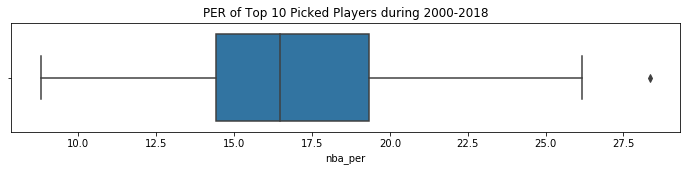

In [19]:
# draw a box-pointer diagram to show the distribution of top ten picked players' PER
draft_top = draft_all_cleaned[draft_all_cleaned['OVERALL_PICK'] <= 10]
plt.figure(figsize=(12,2))
plt.title("PER of Top 10 Picked Players during 2000-2018")
sns.boxplot(x='nba_per', data=draft_top)
print(draft_top['nba_per'].describe())
print("Median PER for all NBA players (in the dataset):", np.median(all_cleaned['nba_per']))

In [20]:
# Due to the special implementation details of joint plot
# in the seaborn libarary, plt.subplot does not work.
# This is code adapted from a staroverflow answer that
# supports arranging sns.jointplot nicely in a custom grid.
# https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movejointgrid(self):
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        # https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

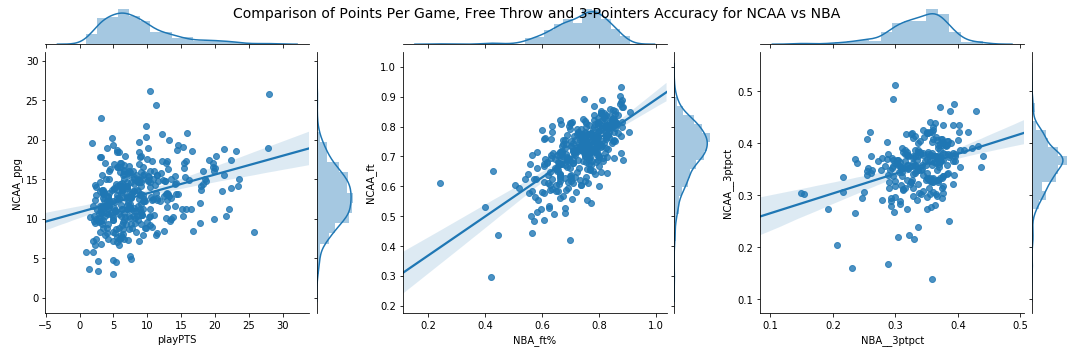

In [21]:
# explore the relationship between college performance and NBA performance in point per game, 
# free throw made per game and three point percentage
# There is a clear positive linear relationship
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)
plt_ppg = sns.jointplot(kind='reg', x='playPTS', y='NCAA_ppg', data=all_cleaned)
plt_rb = sns.jointplot(kind='reg', x='NBA_ft%', y='NCAA_ft', data=all_cleaned)
# three point percentage
draw_three = all_cleaned.loc[(all_cleaned['NBA__3ptapg'] > 0.5) & (all_cleaned['NCAA__3ptapg'] > 0.5), :]
plt_game = sns.jointplot(kind='reg', x='NBA__3ptpct', y='NCAA__3ptpct', data=draw_three)
SeabornFig2Grid(plt_ppg, fig, gs[0])
SeabornFig2Grid(plt_rb, fig, gs[1])
SeabornFig2Grid(plt_game, fig, gs[2])
gs.tight_layout(fig)
fig.suptitle("Comparison of Points Per Game, Free Throw and 3-Pointers Accuracy for NCAA vs NBA", fontsize=14)
plt.show()

In [22]:
# Since we cannot predict a continuous value effectively, we seperate players into different levels for future use in classification
def GetPlayerLevel (per):
      if per > 25:
        return 'MVP Candidate'
      elif per > 20:
        return 'All-Star'
      elif per > 16.5:
        return 'Qualified Starter'
      elif per > 13:
        return 'Rotation Player'
      else:
        return 'Fringe roster Player'

all_cleaned['level'] = all_cleaned['nba_per'].apply(GetPlayerLevel)
all_cleaned['level'].value_counts()

Rotation Player         164
Fringe roster Player    102
Qualified Starter        67
All-Star                 17
MVP Candidate             6
Name: level, dtype: int64

In [23]:
# EDA and data cleaning ends

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [25]:
#train test split for pure college data and NBA PER
train_college, test_college = train_test_split(pure_college, test_size=0.2, random_state=1)
train_per = pure_nba.loc[pure_nba.index.isin(train_college.index), 'nba_per'].sort_index()
test_per = pure_nba.loc[pure_nba.index.isin(test_college.index), 'nba_per'].sort_index()
train_college.sort_index(inplace = True)
test_college.sort_index(inplace = True)

C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# rmse calculator
def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X))**2))

# cross validation error calculator
def CVError (model, X, Y, score):
    return np.mean(cross_val_score(model, X, Y, scoring=score, cv=5))

In [27]:
#predict using dummy model predicting by mean
from sklearn.dummy import DummyRegressor 
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(train_college, train_per)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [28]:
# dummy model errors
dum_cve = CVError(dummy_model, train_college, train_per, rmse_score)
dum_te = rmse_score(dummy_model, train_college, train_per)
# test error is calculated for visualization later
# it does not influence our decision
dum_teste = rmse_score(dummy_model, test_college, test_per)
(dum_cve, dum_te)

(3.43300084395998, 3.437888476119761)

In [29]:
# predict NBA performance based on only college ppg
ppg_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
         ("keep", "passthrough", ['NCAA_ppg'])
    ])),
    ("Imputation", SimpleImputer(strategy='constant')),
    ("LinearModel", LinearRegression())
    ])
ppg_model.fit(train_college, train_per);

In [30]:
# calculate the cross-validation error, training error, and test error of the model
# It is not a good model, but fair amount of improvement from dummy model
ppg_cve = CVError(ppg_model, train_college, train_per, rmse_score)
ppg_te = rmse_score(ppg_model, train_college, train_per)
# test error is calculated for visualization later
# it does not influence our decision
ppg_teste = rmse_score(ppg_model, test_college, test_per)
(ppg_cve, ppg_te)

(3.3839823725714853, 3.3566004275547097)

,predicted,real
name,,
A.J. Price,14.701326,14.982490
Aaron Brooks,14.721438,14.699499
Aaron Gordon,14.580652,17.295835
Aaron Harrison,14.580652,9.967867
Adreian Payne,13.876720,10.479043
...,...,...
DeMarre Carroll,14.339304,15.578052
Dejounte Murray,15.324808,16.442752
Delon Wright,15.103572,17.273579


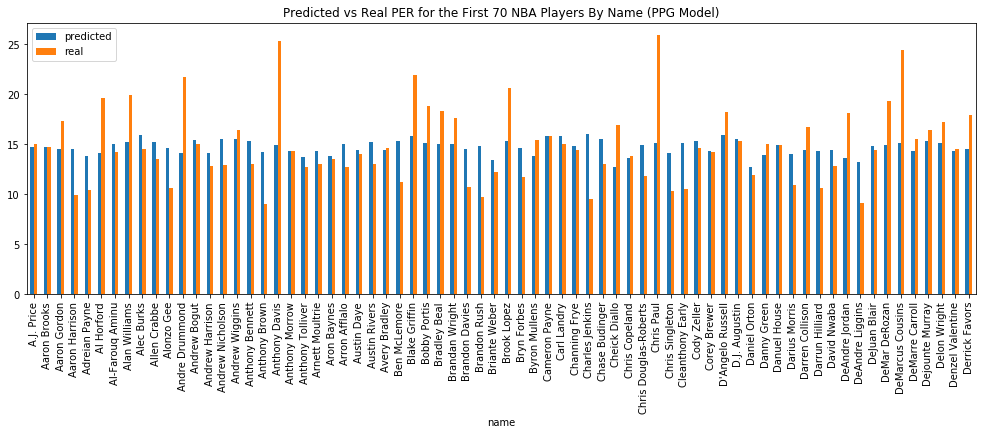

In [31]:
# the predictions of this simple model
ppg_df = pd.DataFrame({'predicted' : ppg_model.predict(train_college.iloc[:70]), 'real' :  train_per.iloc[:70]})
ppg_df.plot(kind='bar', figsize=(17,5))
plt.title("Predicted vs Real PER for the First 70 NBA Players By Name (PPG Model)")
plt.plot()
ppg_df

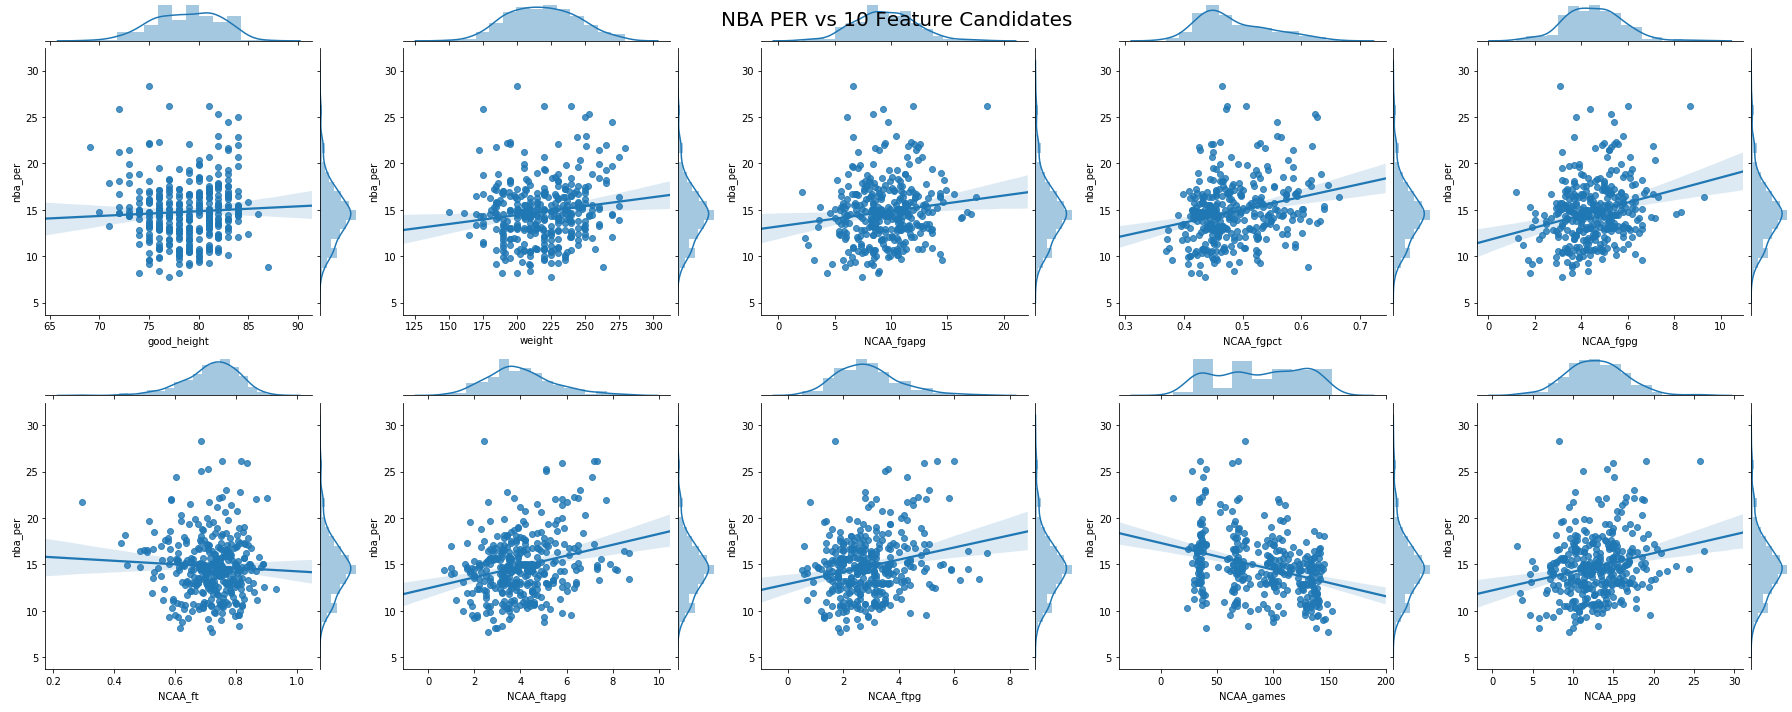

In [32]:
# plot the relationship between each kind of college data and NBA PER (overall performance)
# NOTE: This cell will likely take a few seconds to run, please be patient
# Some features seem to have pretty low relationship with PER
fig = plt.figure(figsize=(25, 10))
gspec = gridspec.GridSpec(2, 5)
i = 0
for param in college_features[5:7]:
    sc = sns.jointplot( kind= 'reg' , x = param, y ='nba_per', data = all_cleaned)
    SeabornFig2Grid(sc, fig, gspec[i])
    i += 1
for param in college_features[10:]:
    sc = sns.jointplot( kind= 'reg' , x = param, y ='nba_per', data = all_cleaned)
    SeabornFig2Grid(sc, fig, gspec[i])
    i += 1
gspec.tight_layout(fig)
fig.suptitle("NBA PER vs 10 Feature Candidates", fontsize=20)
plt.show()

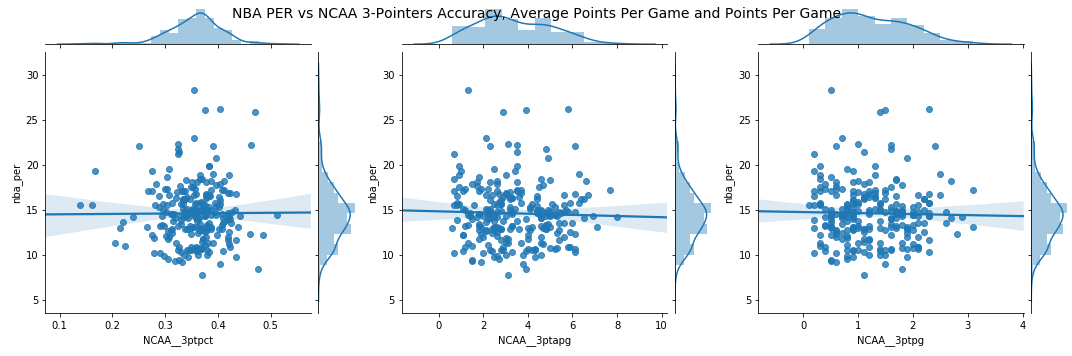

In [33]:
# relationship with three points related features and PER
# This is a surprise as we mentioned in the report.
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)
plt_3pct = sns.jointplot( kind= 'reg' , x = 'NCAA__3ptpct', y ='nba_per', data = draw_three)
plt_3apg = sns.jointplot( kind= 'reg' , x = 'NCAA__3ptapg', y ='nba_per', data = draw_three)
plt_3pg = sns.jointplot( kind= 'reg' , x = 'NCAA__3ptpg', y ='nba_per', data = draw_three)
SeabornFig2Grid(plt_3pct, fig, gs[0])
SeabornFig2Grid(plt_3apg, fig, gs[1])
SeabornFig2Grid(plt_3pg, fig, gs[2])
gs.tight_layout(fig)
fig.suptitle("NBA PER vs NCAA 3-Pointers Accuracy, Average Points Per Game and Points Per Game", fontsize=14)
plt.show()

In [34]:
# build linear model with features that appear to have linear relationship with PER in previous visualizations.
# the model predict a player's PER in NBA based on his college basketball stats
features = ['good_height', 'weight', 'NCAA_fgapg','NCAA_fgpct',	'NCAA_fgpg','NCAA_ftapg', 'NCAA_ftpg', 
            'NCAA_games', 'NCAA_ppg']
sound_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
         ("keep", "passthrough", features),
         ("origin_encoder", OneHotEncoder(), ['first_position'])
    ])),
    ("transformer", StandardScaler()),
    ("Imputation", SimpleImputer(strategy='constant')),
    ("LinearModel", Ridge(alpha=1))
    ])
sound_model.fit(train_college, train_per);


y = sound_model.predict(test_college)

In [35]:
# calculate the cross-validation error, training error, and test error of the model
# It is decent amound of improvement, and this our final linear model errors
cve = np.mean(cross_val_score(sound_model, train_college, train_per, scoring=rmse_score, cv=5))
te = rmse_score(sound_model, train_college, train_per)
teste = rmse_score(sound_model, test_college, test_per)
(cve, te)

(3.0807296766275982, 2.969209210533399)

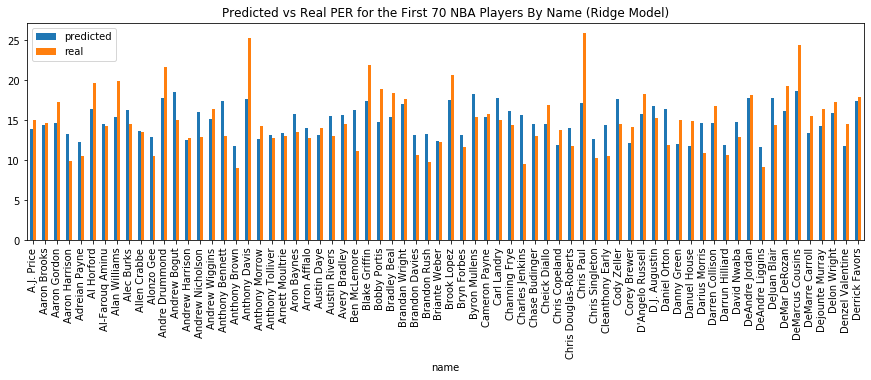

,predicted,real
name,,
A.J. Price,13.894753,14.982490
Aaron Brooks,14.377115,14.699499
Aaron Gordon,14.683640,17.295835
Aaron Harrison,13.294663,9.967867
Adreian Payne,12.325228,10.479043
...,...,...
DeMarre Carroll,13.434887,15.578052
Dejounte Murray,14.342336,16.442752
Delon Wright,15.942067,17.273579


In [36]:
# the predicted PER and real PER for test dataframe
df1 = pd.DataFrame({'predicted' : sound_model.predict(train_college.iloc[:70]),
                    'real' :  train_per[:70]})
df1.plot(kind= 'bar', figsize=(15,4))
plt.title("Predicted vs Real PER for the First 70 NBA Players By Name (Ridge Model)")
plt.show()
df1

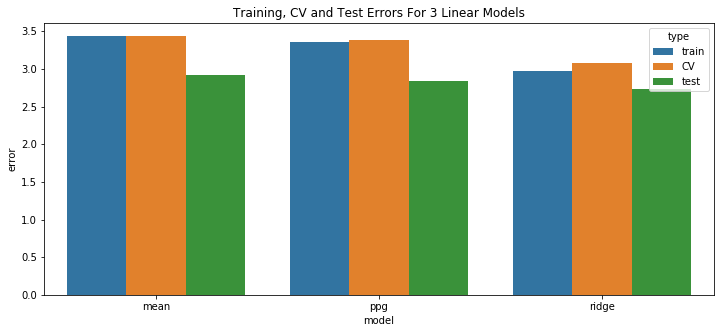

In [37]:
# After finishing all the modeling, we take a look at the improvement of our models and the test errors
compare_models = pd.DataFrame({
    'model': ['mean', 'ppg', 'ridge', 'mean', 'ppg', 'ridge', 'mean', 'ppg', 'ridge'],
    'type': ['train', 'train', 'train', 'CV', 'CV', 'CV', 'test', 'test', 'test'],
    'error': [dum_te, ppg_te, te, dum_cve, ppg_cve, cve, dum_teste, ppg_teste, teste]})
plt.figure(figsize=(12, 5))
sns.barplot(x='model', y='error', hue='type', data=compare_models)
plt.title("Training, CV and Test Errors For 3 Linear Models")
plt.show()

In [38]:
# prepare the training and testing data for classification. 
# We use classification to seperate players into different levels
train_level = all_cleaned['level'][all_cleaned.index.isin(train_college.index)].sort_index()
test_level = all_cleaned['level'][all_cleaned.index.isin(test_college.index)].sort_index()

In [39]:
# decision tree
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn import ensemble
fea = ['good_height', 'weight', 'NCAA_fgapg','NCAA_fgpct', 'NCAA_fgpg',
       'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']

In [40]:
# make the build in accuracy_score callable 
def accuracy_scorer (model, X, y):
    predict_x = model.predict(X)
    return accuracy_score(predict_x, y)

In [41]:
# decision tree selfmade pipeline
def dt_selfpipeline (max_dept, max_child):
    dt_model = tree.DecisionTreeClassifier(max_depth=max_dept, max_leaf_nodes= max_child)
    dt_model.fit(train_college[fea],train_level)

    cv_acc = CVError(dt_model, train_college[fea], train_level, accuracy_scorer)
    train_acc = accuracy_scorer(dt_model, train_college[fea], train_level)
    return train_acc, cv_acc, dt_model
 

In [42]:
# try and find out the best paremeters
all = [] 
for i in range(3, 7):
    for j in range(3, 20):
        train_acc, cv_acc, dt_model= dt_selfpipeline(i, j)
        all.append([train_acc, cv_acc, dt_model, i, j])

df = pd.DataFrame(all)

In [43]:
# The selected model
tree_model = df.loc[df[1] ==  max(df[1]), 2].values[0]
tree_model


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [44]:
# prediction of the decision tree model on training data
pd.Series(tree_model.predict(train_college[fea])).value_counts()

Rotation Player         160
Qualified Starter        90
Fringe roster Player     34
dtype: int64

In [45]:
# calculate the cross validation and testing accuracy
# It seems not pretty accurate, but it fair considering the question is super challenging
dt_cv_acc = CVError(tree_model, train_college[fea], train_level, accuracy_scorer)
dt_cv_acc

0.46420404459424425

In [46]:
# random forest with the same depth and lead nodes limit as those for the best decision tree model found previously
random_forest_model = ensemble.RandomForestClassifier(n_estimators = 20, random_state = 1, max_depth= 6, max_leaf_nodes= 10)
random_forest_model.fit(train_college[fea], train_level)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [47]:
# get the cross validation accuracy
rf_cv_acc = CVError(random_forest_model, train_college[fea], train_level, accuracy_scorer)
rf_cv_acc

0.4581335391770963

In [48]:
# prediction of the random forest model
pd.Series(random_forest_model.predict(train_college[fea])).value_counts()

Rotation Player         204
Fringe roster Player     63
Qualified Starter        14
All-Star                  3
dtype: int64

In [49]:
# the accuracy of testing data
# We prove these are not bad errors in the next cell.
dt_test_acc = accuracy_scorer(tree_model, test_college[fea], test_level)
rf_test_acc = accuracy_scorer(random_forest_model, test_college[fea], test_level)
dt_test_acc, rf_test_acc

(0.4583333333333333, 0.4444444444444444)

In [50]:
# how does our random forest stack up against real scouts?
expected_stars = draft_all_cleaned[draft_all_cleaned['OVERALL_PICK'] <= 5]
expected_starters = draft_all_cleaned[draft_all_cleaned['OVERALL_PICK'] <= 30]
print("Real scouts get ", len(expected_stars[expected_stars['nba_per'] > 20].index)
      / len(expected_stars.index), "correct for All-star or above")
print("Real scouts get ", len(expected_stars[expected_stars['nba_per'] > 16.5].index)
      / len(expected_stars.index), "correct for Qualified starter or above")

Real scouts get  0.3023255813953488 correct for All-star or above
Real scouts get  0.5116279069767442 correct for Qualified starter or above
